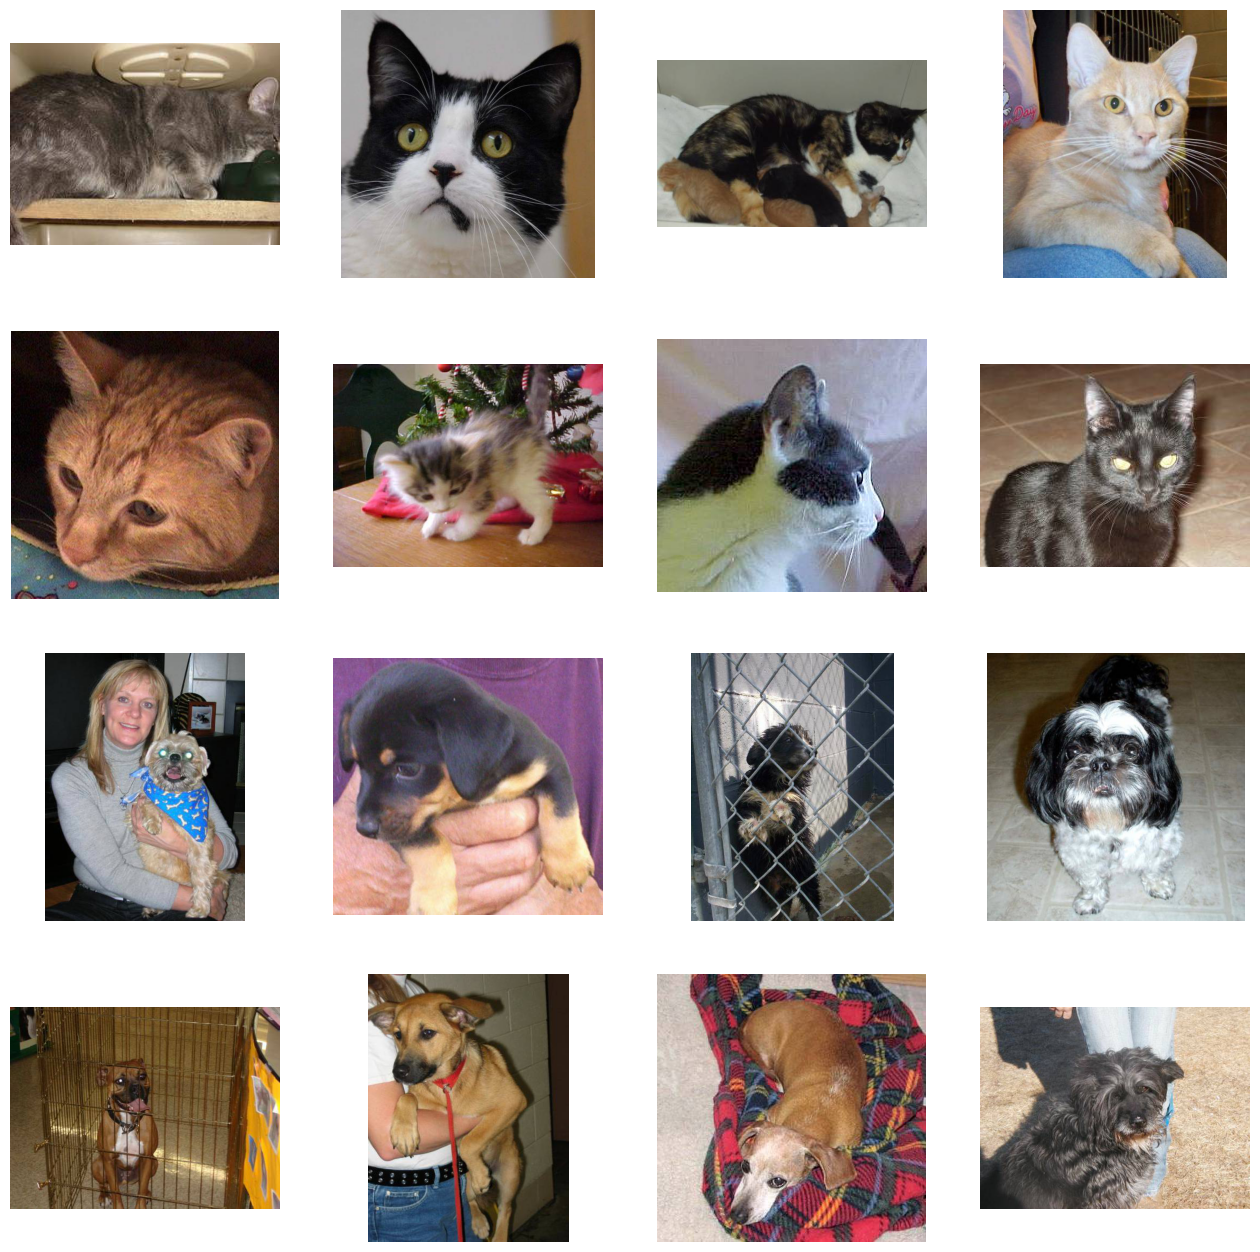

e:\Anaconda\envs\pytorch_env\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/2, Loss: 0.1346, Val Loss: 0.0888, Acc: 0.9468, Val Acc: 0.9608


Epoch 2/2, Loss: 0.0303, Val Loss: 0.0759, Acc: 0.9909, Val Acc: 0.9700
模型已保存到 'dog_vs_cat_model.pth'


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s]

Test Loss: 0.0789, Test Accuracy: 97.00%


(0.07892856844034536, 97.00499168053244)

In [64]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
from PIL import Image
from tqdm import tqdm  # 导入 tqdm

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 显示图片
path = 'dog-vs-cat-classification'
classes = os.listdir(path)

fig = plt.gcf()
fig.set_size_inches(16, 16)

cat_dir = os.path.join(path, 'cat')
dog_dir = os.path.join(path, 'dog')
cat_names = os.listdir(cat_dir)
dog_names = os.listdir(dog_dir)

pic_index = 210
cat_images = [os.path.join(cat_dir, fname) for fname in cat_names[pic_index-8:pic_index]]
dog_images = [os.path.join(dog_dir, fname) for fname in dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(cat_images + dog_images):
    sp = plt.subplot(4, 4, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# 数据预处理
base_dir = 'dog-vs-cat-classification'

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.RandomRotation(30),  # 增加旋转角度
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 添加颜色抖动
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # 添加仿射变换
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 使用 ImageNet 均值和标准差
])

val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 数据集划分
dataset = ImageFolder(base_dir, transform=train_transforms)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 使用 ResNet18
from torchvision.models import resnet18
class ResNetClassifier(nn.Module):
    def __init__(self):
        super(ResNetClassifier, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.resnet(x)

model = ResNetClassifier().to(device)



# 优化器和调度器
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# 训练和评估
history = train_model(model, train_loader, val_loader, epochs=2)

# 保存模型
torch.save(model.state_dict(), 'dog_vs_cat_model.pth')
print("模型已保存到 'dog_vs_cat_model.pth'")

# 定义 evaluate_model 函数
def evaluate_model(model, test_loader):
    model.eval()
    criterion = nn.BCELoss()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item() * images.size(0)
            predicted = (outputs.squeeze() >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total * 100
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

evaluate_model(model, test_loader)



In [ ]:
# 绘制训练曲线
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

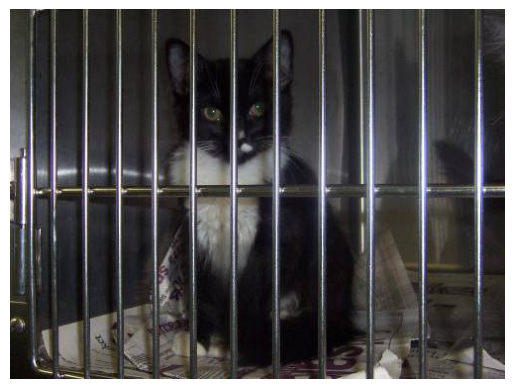

预测结果: 猫 (置信度: 98.35%)


In [76]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

# 设置设备（假设已定义）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 预测函数（保持不变）
def predict_image(image_path, model_path='dog_vs_cat_model.pth'):
    model = ResNetClassifier().to(device)  # 使用 ResNetClassifier
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 与训练一致
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    with torch.no_grad():
        prediction = model(img_tensor)
        confidence = prediction.item()
    
    if prediction >= 0.5:
        print(f"预测结果: 狗 (置信度: {confidence*100:.2f}%)")
    else:
        print(f"预测结果: 猫 (置信度: {(1-confidence)*100:.2f}%)")

# 随机读取图片函数
def read_random_image():
    base_folder = r"datasets\test"
    categories = ['dog', 'cat']
    chosen_category = random.choice(categories)
    folder = os.path.join(base_folder, chosen_category)
    file_path = os.path.join(folder, random.choice(os.listdir(folder)))
    return file_path

# 测试
file_path = read_random_image()
predict_image(file_path)